In [1]:
autodir = "../loss_testset_T5_autoreg"
singdir = "../loss_testset_T5_singlepass"

import os
import numpy as np
import json

single_dict = {}
auto_dict = {}

for filename in os.listdir(autodir):
    if filename.endswith(".json"):
        uniprot_id = filename.split(".")[0]
        with open(os.path.join(autodir, filename)) as f:
            data = json.load(f)
            auto_dict[uniprot_id] = data[uniprot_id]

for filename in os.listdir(singdir):
    if filename.endswith(".json"):
        uniprot_id = filename.split(".")[0]
        with open(os.path.join(singdir, filename)) as f:
            data = json.load(f)
            single_dict[uniprot_id] = data[uniprot_id]

In [2]:
common_uniprots = sorted(set.intersection(set(auto_dict.keys()), set(single_dict.keys())))
common_uniprots

{'O00488',
 'P02686',
 'P04637',
 'P06401',
 'P07305',
 'P23441',
 'P37840',
 'Q16186',
 'Q9NYB9',
 'S6B291'}

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('../models/prottrans_t5_xl_u50', do_lower_case=False, legacy=False)

from Bio import SeqIO

fasta_dict = dict()
for record in SeqIO.parse("../testset_sequences.fasta", "fasta"):
    print(record.id)
    fasta_dict[record.id] = str(record.seq)

diso_dict = dict()
for record in SeqIO.parse("../testset_annotations.fasta", "fasta"):
    diso_dict[record.id] = str(record.seq)

P04637
P02686
O00488
P37840
Q9NYB9
Q16186
P06401
P23441
P07305
S6B291


In [4]:
import re
from torch.nn import CrossEntropyLoss

celoss = CrossEntropyLoss()

def get_single_aa_losses(datadict, prot_tokens):
    all_loss_sequences = []
    logits = datadict['aamask_1']['logits']
    for i in range(len(prot_tokens)):
        aaloss_sequence = []
        if datadict['aamask_1']['loss'][i] < 0:
            aaloss_sequence.append(-1)
        else:
            for j in range(len(prot_tokens)):
                loss = celoss(torch.tensor(logits[i][j]), torch.tensor(prot_tokens[j]))   
                aaloss_sequence.append(loss.item())
        all_loss_sequences.append(aaloss_sequence)
    return all_loss_sequences


data_loss_sequences = dict()
for unip in common_uniprots:
    input_seq = " ".join(list(re.sub(r"[UZOB]", "X", fasta_dict[unip])))
    prot_toks = tokenizer(input_seq)['input_ids'][:-1] ## remove end of sequence token
    print(unip, len(prot_toks))
   
    singlepass_aaloss_sequences = get_single_aa_losses(single_dict[unip], prot_toks)
    autoreg_aaloss_sequences    = get_single_aa_losses(auto_dict[unip], prot_toks)

    singlepass_prot_loss_sequence = single_dict[unip]['aamask_1']['loss']
    autoreg_prot_loss_sequence = auto_dict[unip]['aamask_1']['loss']

    data_loss_sequences[unip] = dict()
    data_loss_sequences[unip]['tokens'] = prot_toks
    data_loss_sequences[unip]['aa_singlepass'] = singlepass_aaloss_sequences
    data_loss_sequences[unip]['prot_singlepass'] = singlepass_prot_loss_sequence
    data_loss_sequences[unip]['aa_autoreg'] = autoreg_aaloss_sequences
    data_loss_sequences[unip]['prot_autoreg'] = autoreg_prot_loss_sequence

O00488 134
P06401 933
P02686 304
P37840 140
P23441 372
P04637 393
Q9NYB9 513
S6B291 466
P07305 194
Q16186 407


In [5]:
def get_position_colors(unip, diso_dict):
    aa_colors = []
    for e in diso_dict[unip]:
        if e == "-":
            aa_colors.append('b')
        else:
            aa_colors.append('r')
    return aa_colors

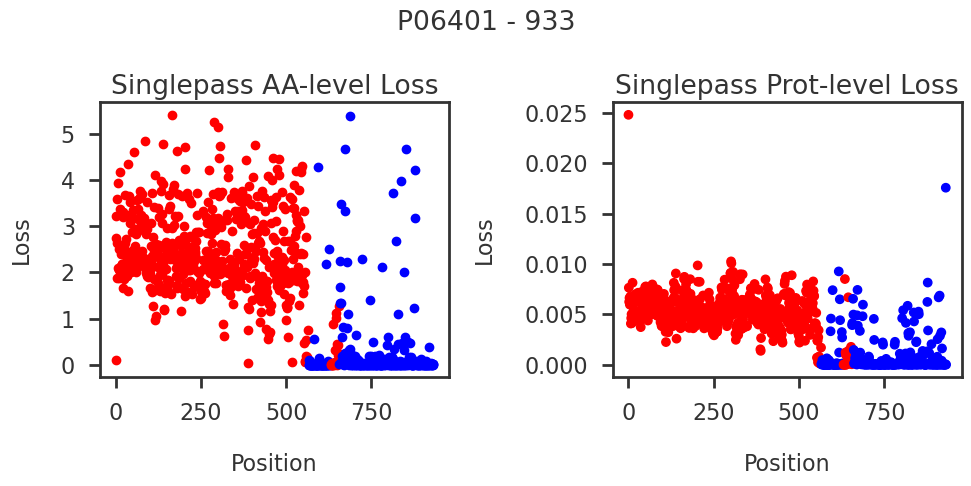

In [6]:
import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 16)

unip = list(common_uniprots)[1]

prot_toks = data_loss_sequences[unip]['tokens']
singlepass_aaloss_sequences = data_loss_sequences[unip]['aa_singlepass']
singlepass_prot_loss_sequence = data_loss_sequences[unip]['prot_singlepass']
aa_colors = get_position_colors(unip, diso_dict)

# for i in range(len(prot_toks)):
#     plt.plot(range(len(prot_toks)), singlepass_aaloss_sequences[i], color=aa_colors[i])
# plt.show()

fig = plt.figure(figsize=(10, 5), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(len(prot_toks)):
    ax1.scatter(i, singlepass_aaloss_sequences[i][i], color=aa_colors[i])
ax1.set_ylabel("Loss")
ax1.set_xlabel("Position")
ax1.set_title("Singlepass AA-level Loss")

ax2.scatter(range(len(prot_toks)), singlepass_prot_loss_sequence, color=aa_colors)
ax2.set_ylabel("Loss") 
ax2.set_xlabel("Position")
ax2.set_title("Singlepass Prot-level Loss")

plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
plt.tight_layout() #rect=[0, 0, 1, 1])
plt.show()

In [7]:
unip

'P06401'

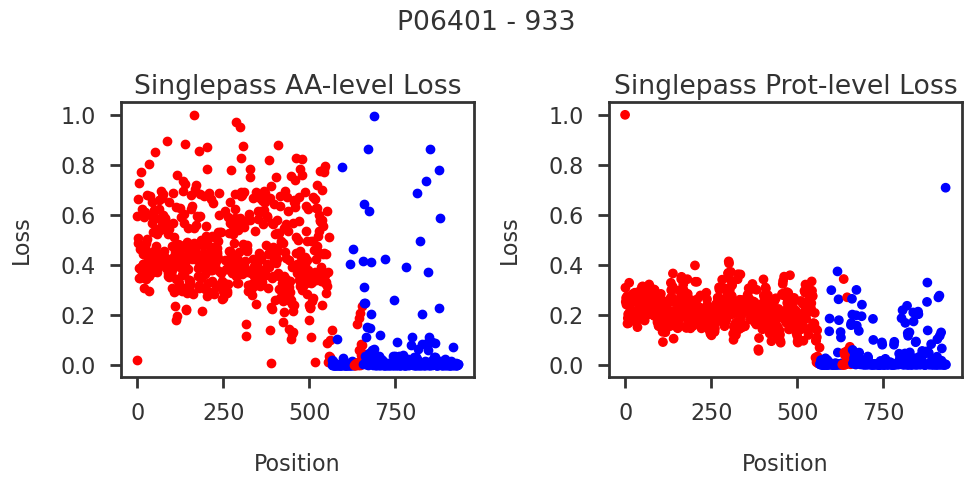

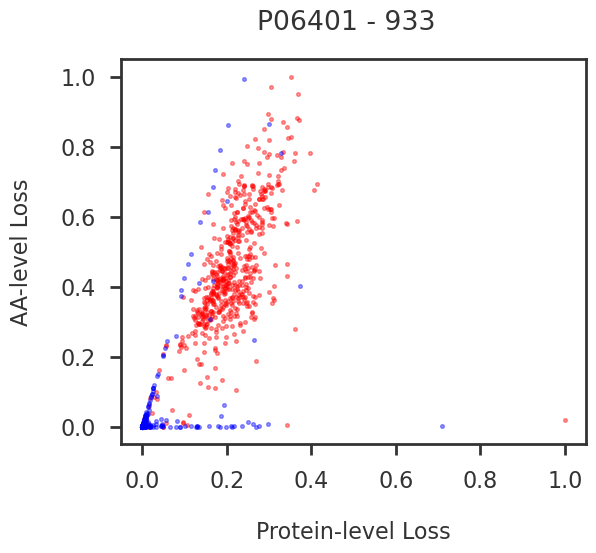

In [8]:
import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 16)

def minmax_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

prot_toks = data_loss_sequences[unip]['tokens']

singlepass_aaloss_sequences = np.array(data_loss_sequences[unip]['aa_singlepass'])
singlepass_aaloss_sequences = minmax_normalize(np.array([singlepass_aaloss_sequences[i][i] for i in range(singlepass_aaloss_sequences.shape[0])]))

singlepass_prot_loss_sequence = np.array(data_loss_sequences[unip]['prot_singlepass'])
singlepass_prot_loss_sequence = minmax_normalize(singlepass_prot_loss_sequence)
aa_colors = get_position_colors(unip, diso_dict)

# for i in range(len(prot_toks)):
#     plt.plot(range(len(prot_toks)), singlepass_aaloss_sequences[i], color=aa_colors[i])
# plt.show()

fig = plt.figure(figsize=(10, 5), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(len(prot_toks)):
    ax1.scatter(i, singlepass_aaloss_sequences[i], color=aa_colors[i])
ax1.set_ylabel("Loss")
ax1.set_xlabel("Position")
ax1.set_title("Singlepass AA-level Loss")

ax2.scatter(range(len(prot_toks)), singlepass_prot_loss_sequence, color=aa_colors)
ax2.set_ylabel("Loss") 
ax2.set_xlabel("Position")
ax2.set_title("Singlepass Prot-level Loss")

plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
plt.tight_layout() #rect=[0, 0, 1, 1])
plt.show()


fig = plt.figure(figsize=(6, 5), dpi=100)
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)

for i in range(len(prot_toks)):
    ax1.scatter(singlepass_prot_loss_sequence[i], singlepass_aaloss_sequences[i], s=7, alpha=0.4, color=aa_colors[i])
ax1.set_ylabel("AA-level Loss")
ax1.set_xlabel("Protein-level Loss")
plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
plt.show()

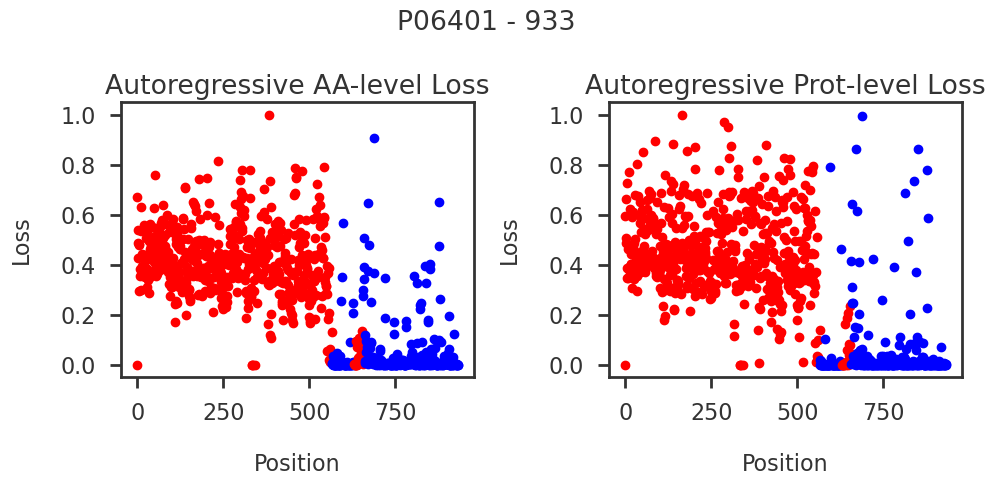

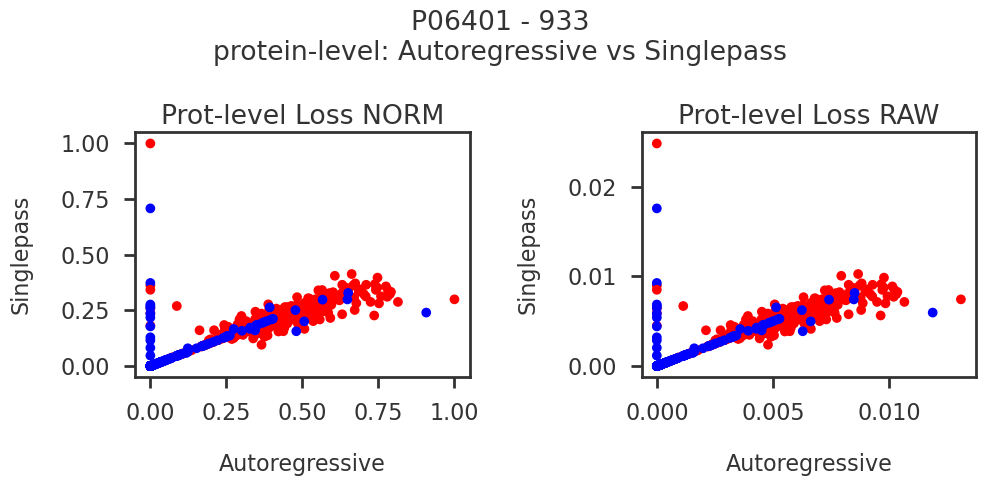

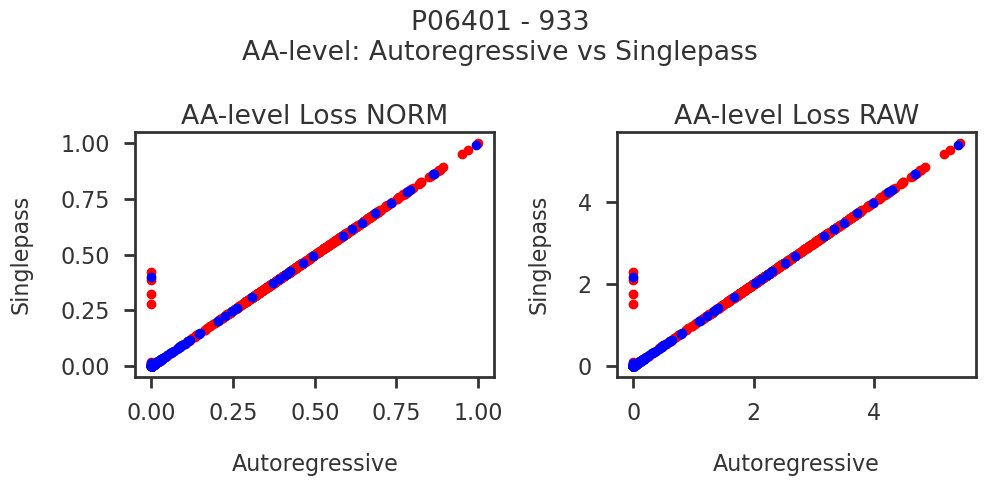

In [9]:
prot_toks = data_loss_sequences[unip]['tokens']

singlepass_aaloss_sequences_raw = np.array(data_loss_sequences[unip]['aa_singlepass'])
singlepass_aaloss_sequences = minmax_normalize(np.array([singlepass_aaloss_sequences_raw[i][i] for i in range(singlepass_aaloss_sequences_raw.shape[0])]))
singlepass_prot_loss_sequence_raw = data_loss_sequences[unip]['prot_singlepass']
singlepass_prot_loss_sequence = minmax_normalize(singlepass_prot_loss_sequence_raw)


aa_colors = get_position_colors(unip, diso_dict)

autoreg_aaloss_sequences = data_loss_sequences[unip]['aa_autoreg']
tmp = []
for i in range(len(fasta_dict[unip])):
    if len(autoreg_aaloss_sequences[i]) == 1:
        tmp.append(0)
    else:
        tmp.append(autoreg_aaloss_sequences[i][i])

minval = sorted(set(tmp))[1]
tmp[ tmp == 0] = minval
autoreg_aaloss_sequences_raw = tmp    
autoreg_aaloss_sequences = minmax_normalize(np.array(tmp))

autoreg_prot_loss_sequence_raw = np.array(data_loss_sequences[unip]['prot_autoreg'])
autoreg_prot_loss_sequence_raw[ autoreg_prot_loss_sequence_raw == -1 ] = 0
autoreg_prot_loss_sequence = minmax_normalize(autoreg_prot_loss_sequence_raw)


fig = plt.figure(figsize=(10, 5), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# for i in range(len(prot_toks)):
#         ax1.scatter(autoreg_prot_loss_sequence[i], autoreg_aaloss_sequences[i], s=5, alpha=0.3, color=aa_colors[i])
# plt.title("protein-level vs aa-level loss : autoreg")
# plt.show()

for i in range(len(prot_toks)):
    ax1.scatter(i, autoreg_prot_loss_sequence[i], color=aa_colors[i])
    ax2.scatter(i, autoreg_aaloss_sequences[i], color=aa_colors[i])
ax1.set_xlabel("Position")
ax1.set_ylabel("Loss")
ax2.set_xlabel("Position")
ax2.set_ylabel("Loss")
ax1.set_title("Autoregressive AA-level Loss")
ax2.set_title("Autoregressive Prot-level Loss")
plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,5), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(autoreg_prot_loss_sequence, singlepass_prot_loss_sequence, color=aa_colors)
ax2.scatter(autoreg_prot_loss_sequence_raw, singlepass_prot_loss_sequence_raw, color=aa_colors)
ax1.set_title("Prot-level Loss NORM")
ax2.set_title("Prot-level Loss RAW")
ax1.set_xlabel("Autoregressive")
ax1.set_ylabel("Singlepass")
ax2.set_xlabel("Autoregressive")
ax2.set_ylabel("Singlepass")
plt.suptitle(f"{unip} - {len(fasta_dict[unip])}\nprotein-level: Autoregressive vs Singlepass")
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(10,5), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(len(prot_toks)):
    ax1.scatter(autoreg_aaloss_sequences[i], singlepass_aaloss_sequences[i], color=aa_colors[i])
    ax2.scatter(autoreg_aaloss_sequences_raw[i], singlepass_aaloss_sequences_raw[i][i], color=aa_colors[i])
ax1.set_title("AA-level Loss NORM")
ax2.set_title("AA-level Loss RAW")
ax1.set_xlabel("Autoregressive")
ax1.set_ylabel("Singlepass")
ax2.set_xlabel("Autoregressive")
ax2.set_ylabel("Singlepass")
plt.suptitle(f"{unip} - {len(fasta_dict[unip])}\nAA-level: Autoregressive vs Singlepass")
plt.tight_layout()
plt.show()

# for i in range(len(prot_toks)):
#     if len(autoreg_aaloss_sequences[i]) == 1:
#         plt.scatter(0,0)
#     else:
#         plt.scatter(autoreg_aaloss_sequences[i][i], singlepass_aaloss_sequences[i][i], s=5, alpha=0.3, color=aa_colors[i])
# plt.title("aa-level: autoreg vs singlepass")
# plt.show()



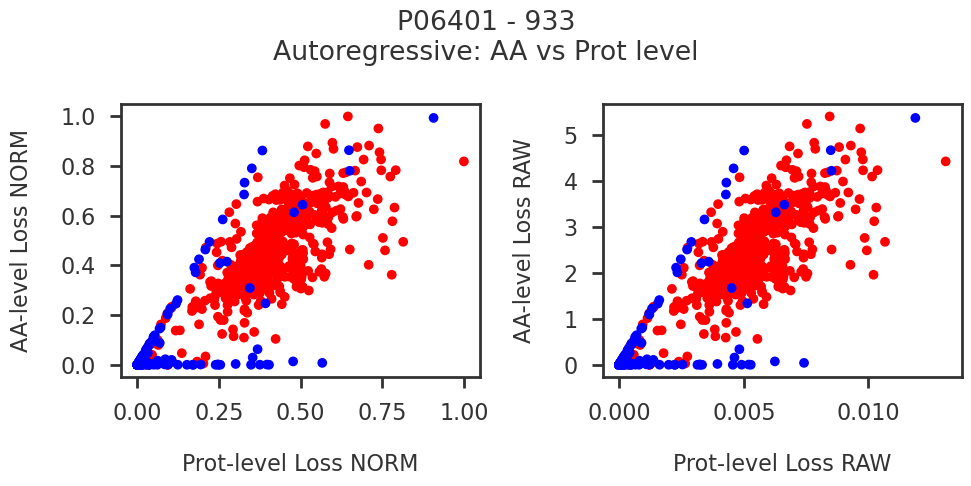

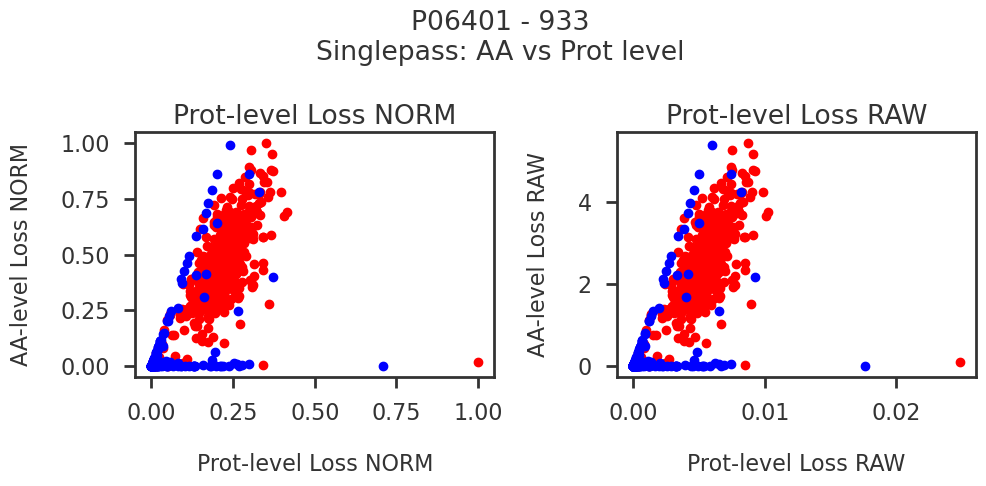

In [10]:
fig = plt.figure(figsize=(10,5), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(autoreg_prot_loss_sequence, autoreg_aaloss_sequences, color=aa_colors)
ax2.scatter(autoreg_prot_loss_sequence_raw, autoreg_aaloss_sequences_raw, color=aa_colors)
ax1.set_xlabel("Prot-level Loss NORM")
ax1.set_ylabel("AA-level Loss NORM")
ax2.set_xlabel("Prot-level Loss RAW")
ax2.set_ylabel("AA-level Loss RAW")
plt.suptitle(f"{unip} - {len(fasta_dict[unip])}\nAutoregressive: AA vs Prot level")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,5), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(len(prot_toks)):
    ax1.scatter(singlepass_prot_loss_sequence[i], singlepass_aaloss_sequences[i], color=aa_colors[i])
    ax2.scatter(singlepass_prot_loss_sequence_raw[i], singlepass_aaloss_sequences_raw[i][i], color=aa_colors[i])
ax1.set_title("Prot-level Loss NORM")
ax2.set_title("Prot-level Loss RAW")
ax1.set_xlabel("Prot-level Loss NORM")
ax1.set_ylabel("AA-level Loss NORM")
ax2.set_xlabel("Prot-level Loss RAW")
ax2.set_ylabel("AA-level Loss RAW")
plt.suptitle(f"{unip} - {len(fasta_dict[unip])}\nSinglepass: AA vs Prot level")
plt.tight_layout()
plt.show()

# fig = plt.figure(figsize=(10,5), dpi=100)
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# for i in range(len(prot_toks)):
#     ax1.scatter(autoreg_aaloss_sequences[i], singlepass_aaloss_sequences[i], color=aa_colors[i])
#     ax2.scatter(autoreg_aaloss_sequences_raw[i], singlepass_aaloss_sequences_raw[i][i], color=aa_colors[i])
# ax1.set_title("AA-level Loss NORM")
# ax2.set_title("AA-level Loss RAW")
# ax1.set_xlabel("Autoregressive")
# ax1.set_ylabel("Singlepass")
# ax2.set_xlabel("Autoregressive")
# ax2.set_ylabel("Singlepass")
# plt.suptitle(f"{unip} - {len(fasta_dict[unip])}\nAA-level: Autoregressive vs Singlepass")
# plt.tight_layout()
# plt.show()

In [11]:
masked_loc_diff = []
for i in range(len(prot_toks)):
    maxval = np.max(singlepass_aaloss_sequences_raw[i])
    maxloc = np.where(singlepass_aaloss_sequences_raw[i] >= maxval)[0]
    local_diff = []
    for j in range(len(maxloc)):
        local_diff.append(str(maxloc[j]-i))
    masked_loc_diff.append(local_diff)

import json
with open(f'masked_loc_diff_{unip}.json', 'w') as fp:
    json.dump(masked_loc_diff, fp)
#print(masked_loc_diff)

In [12]:
json.dumps(masked_loc_diff)

'[["2"], ["1"], ["1"], ["1"], ["0"], ["1"], ["0"], ["0"], ["1"], ["0"], ["0"], ["1"], ["0"], ["0"], ["1"], ["1"], ["0"], ["1"], ["1"], ["0"], ["1"], ["1"], ["0"], ["0"], ["0"], ["1"], ["0"], ["1"], ["0"], ["0"], ["0"], ["0"], ["1"], ["0"], ["1"], ["0"], ["1"], ["1"], ["1"], ["0"], ["0"], ["1"], ["0"], ["0"], ["0"], ["1"], ["0"], ["0"], ["1"], ["1"], ["0"], ["1"], ["0"], ["1"], ["1"], ["0"], ["0"], ["0"], ["1"], ["0"], ["1"], ["0"], ["1"], ["0"], ["0"], ["1"], ["0"], ["0"], ["1"], ["1"], ["0"], ["0"], ["0"], ["0"], ["0"], ["1"], ["0"], ["0"], ["0"], ["1"], ["1"], ["1"], ["0"], ["0"], ["0"], ["1"], ["0"], ["1"], ["0"], ["1"], ["0"], ["1"], ["0"], ["0"], ["1"], ["0"], ["0"], ["0"], ["0"], ["0"], ["0"], ["1"], ["0"], ["1"], ["1"], ["0"], ["0"], ["1"], ["1"], ["0"], ["0"], ["0"], ["1"], ["0"], ["1"], ["1"], ["0"], ["1"], ["1"], ["0"], ["1"], ["1"], ["0"], ["1"], ["1"], ["0"], ["1"], ["0"], ["1"], ["0"], ["1"], ["0"], ["1"], ["0"], ["0"], ["0"], ["0"], ["0"], ["1"], ["0"], ["0"], ["0"], ["1"

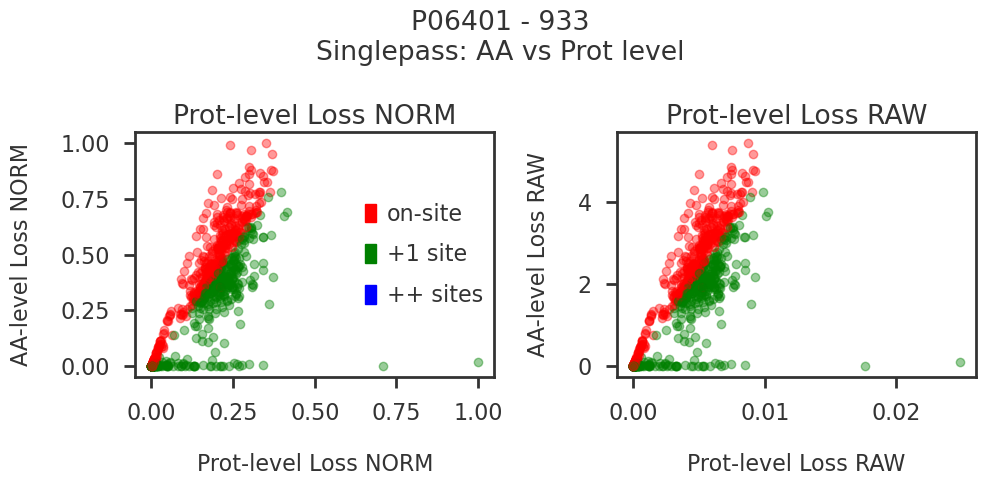

In [21]:

from matplotlib.patches import Patch

diff_colors = []
for e in masked_loc_diff:
    if len(e) > 1:
        diff_colors.append('b')
    else:
        if int(e[0]) == 0:
            diff_colors.append('r')
        else:
            diff_colors.append('g')


fig = plt.figure(figsize=(10,5), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(len(prot_toks)):
    ax1.scatter(singlepass_prot_loss_sequence[i], singlepass_aaloss_sequences[i], alpha=0.4, color=diff_colors[i])
    ax2.scatter(singlepass_prot_loss_sequence_raw[i], singlepass_aaloss_sequences_raw[i][i], alpha=0.4, color=diff_colors[i])
ax1.set_title("Prot-level Loss NORM")
ax2.set_title("Prot-level Loss RAW")
ax1.set_xlabel("Prot-level Loss NORM")
ax1.set_ylabel("AA-level Loss NORM")
ax2.set_xlabel("Prot-level Loss RAW")
ax2.set_ylabel("AA-level Loss RAW")

legend_elements = [ Patch(facecolor='red', edgecolor='r', label='on-site'),
                    Patch(facecolor='green', edgecolor='g', label='+1 site'),
                    Patch(facecolor='blue', edgecolor='b', label='++ sites')]
ax1.legend(handles=legend_elements, loc='right')

plt.suptitle(f"{unip} - {len(fasta_dict[unip])}\nSinglepass: AA vs Prot level\nHighest Loss Position")
plt.tight_layout()
plt.show()

In [18]:
e[0]

'0'